Загрузим необходимые нам библиотеки, sns и plt для визуализации, numpy и pandas для работы с базой данных, datetime понадобится для смены типа Time Start на дату 

In [1]:
import datetime
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
#matplotlib inline

Загрузим документ, присвоим его к переменной df и посмотрим на его признаки 

In [2]:
df = pd.read_csv('query_result_2019-12-24T07_29_06.659397Z.csv')
df.head(2)

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
0,2019-05-05T09:40:00+03:00,2019-05-05T12:40:00+03:00,10800,2019-05-05T09:39:59+03:00,2019-05-05T12:39:59+03:00,2166,1.0
1,2019-05-05T11:13:29+03:00,2019-05-05T14:13:29+03:00,10800,2019-05-05T11:12:51+03:00,2019-05-05T14:12:51+03:00,2166,34.0


У нас 4 признака времени, предлагаю оставить только 1 - TimeStart, Time Offset имеет два значения, так что он тоже не несет в себе смысла, User ID  у нас один, значит мы исследуем показания одного человека, поэтому и этот столбец удалим. 
##### Соединим все записи за один день в одну.
##### Занесем все, что осталось в df1 - датафрэйм Число шагов в день

In [3]:
df['Time Start'] = df['Time Start'].map(lambda x:str(x)[:10])
df1 = df.pivot_table(['Value'],['Time Start'], aggfunc = 'sum').reset_index().copy()
df1['Time Start'] = pd.to_datetime(df1['Time Start'])
df1.head()

,Time Start,Value
0,2019-05-01,21.0
1,2019-05-02,12956.0
2,2019-05-03,17003.0
3,2019-05-04,14312.0
4,2019-05-05,11124.0


Посмотрим информацию о df1

In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
Time Start    105 non-null datetime64[ns]
Value         105 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.7 KB


Визуализируем информацию, с помощью графика plot

Text(0.5, 1.0, 'Число шагов по дням')

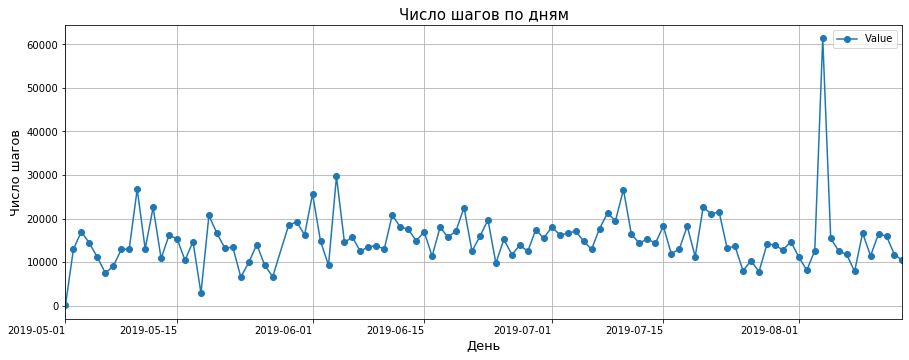

In [5]:
df1.plot(x='Time Start', y='Value', rot = 0, figsize=(15, 6), grid=True, marker='o')
plt.xlabel('День', fontsize = 13)
plt.ylabel('Число шагов', fontsize = 13)
plt.title('Число шагов по дням', fontsize = 15)

# Математическая статистика

#### Построим распределение Value

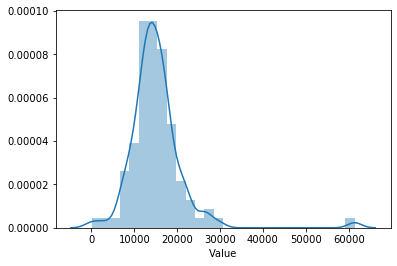

In [6]:
sns.distplot(df1.Value)

#### Проверим является ли оно нормальным с помощью критерия Шапиро

In [7]:
from scipy import stats

In [8]:
res = stats.shapiro(df1['Value'])
print('p-value',res[1])

p-value 5.563884422632448e-12


#### Слишком маленькое значение критерия, давайте попробуем выбросить непонятное значение на 60000 шагах, ниже будет обоснование почему это выброс или нет.
p.s. там целое расследование насчет выброса :)

In [9]:
df1_no_outliers = df1[(df1.Value < 40000)]
df1_no_outliers.shape

(104, 2)

#### Посчитаем еще раз критерий Шапиро и построим distplot

p-value: 0.06258922815322876


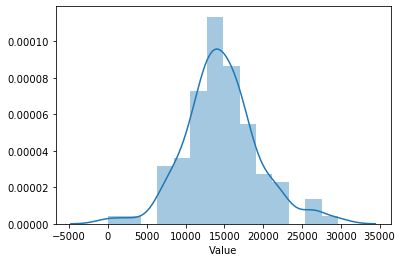

In [10]:
_, p = stats.shapiro(df1_no_outliers.Value)
sns.distplot(df1_no_outliers.Value)

print("p-value: {}".format(p))

#### Уже лучше, 0.06 допустимое значение для alpha

# _

#### Посчитаем медиану и стандартное отклонение и сделаем интервалы ±2σ и ±3σ
#### ±3σ потому что есть правило трех сигм, а ±2σ потому что видел пару раз этот прием по-моему  в лекциях OpenDataScience по машинному обучению на youtube, но теоритически обосновать не могу... 

In [11]:
median = df1_no_outliers['Value'].median()
std = df1_no_outliers['Value'].std()
print('Медиана = '+str(median)+'\nСтандартное отклонение = '+str(std))

Медиана = 14315.5
Стандартное отклонение = 4752.138886977131


In [12]:
df1_no_outliers.describe()

,Value
count,104.000000
mean,14643.365385
std,4752.138887
min,21.000000
25%,11897.250000
50%,14315.500000
75%,17033.250000
max,29658.000000


In [13]:
left1  = median - 2*std
right1 = median + 2*std
print('Значения находящиеся интервале ДВУХ сигм  \n'+'Левый край = '+str(left1)+'\nПравый край = '+str(right1))

Значения находящиеся интервале ДВУХ сигм  
Левый край = 4811.222226045738
Правый край = 23819.77777395426


In [14]:
left2  = median - 3*std
right2 = median + 3*std
print('Значения находящиеся интервале ТРЕХ сигм  '+'\nЛевый край = '+str(left2)+'\nПравый край = '+str(right2))

Значения находящиеся интервале ТРЕХ сигм  
Левый край = 59.08333906860753
Правый край = 28571.91666093139


#### Посмотрим на значения которые попали в эти интервалы

#### Эти значения можно назвать необычными днями

In [15]:
df1[(((df1.Value > right1) &(df1.Value < right2)) | ((df1.Value < left1) & (df1.Value > left2)))]

,Time Start,Value
9,2019-05-10,26759.0
17,2019-05-18,2854.0
30,2019-06-01,25641.0
69,2019-07-10,26629.0


#### Эти значения можно назвать непонятными днями

In [16]:
df1[(df1.Value > right2) | (df1.Value < left2)]

,Time Start,Value
0,2019-05-01,21.0
33,2019-06-04,29658.0
94,2019-08-04,61392.0


#### Добавим на нашу визуализацию интервалы.

Text(0.5, 1.0, 'Число шагов по дням')

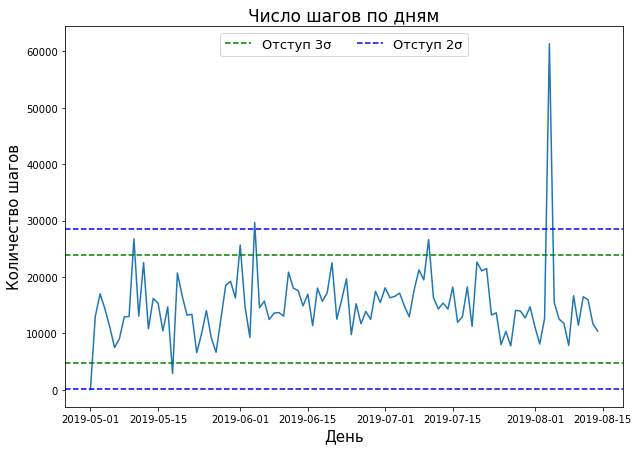

In [17]:
x = np.array(df1['Time Start'])
y = np.array(df1['Value'])
plt.plot(x, y)
fig = plt.gcf()
fig.set_size_inches(10, 7, forward=True)
plt.axhline(left1,color='green',linestyle='--', label = 'Отступ 3σ')
plt.axhline(right1,color='green',linestyle='--')
plt.axhline(left2,color='blue',linestyle='--', label = 'Отступ 2σ')
plt.axhline(right2,color='blue',linestyle='--')
plt.legend(loc = 'upper center', ncol=2, fontsize = 13)

plt.xlabel('День', fontsize = 15)
plt.ylabel('Количество шагов', fontsize = 15)
plt.title('Число шагов по дням', fontsize = 17)

# Машинное обучение

Не могу понять хороший результат получился или нет, наверное стоит применить какой нибудь метод машинного обучения, а потом выбрать метрику оценки и посмотреть что получается.

Какой метод выбрать?
https://habr.com/ru/company/ods/blog/325654/
тут есть табличка, где сравниваются различные алгоритмы, конечно K-Means не идеален, но нам уже известно число кластеров и сам по себе алгоритм достаточно прост в использовании, поэтому остановился на нем, чуть ниже сравним его с другими алгоритмами.

In [18]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics



#### Применим K-means к нашим данным и визуализируем разбиение по кластерам в разрезе  Дней и Числа шагов.

Именуем кластеры

##### Cluster 0 - Обычный день
##### Cluster 1 - Непонятный(выброс)
##### Cluster 2 - Необычный(ходили больше, чем обычно)
##### Cluster 3 - Необычный(ходили меньше, чем обычно)


#### неизвестно, обычный или необычный 
можно слово неизвестно понять по-разному, либо как выброс,  либо как что то среднее между обычным и необычным

### Пояснения, если думать, что НЕПОНЯТНЫЙ - это что то среднее между обычным и необычным
Три кластера мало, ведь наш день где 60000 тысяч шагов перетягивает на себя весь кластер, а нам для непонятных дней нужно выделить два кластера (БОЛЬШЕ чем обычно, МЕНЬШЕ чем обычно) в итоге уже минимум 4 кластера, поэтому добавляем один кластер для него и можно взять 6,8 кластеров например, можно применить метод локтя или силуэт (я применю силуэт) чтобы понять что лучше 4,6 или 8, а так же рассмотреть свою ситуацию и поспрашивать у знакомых какая у них пропорция (сумма за месяц непонятных дней)/(сумма за месяц обычных дней)


Лучшее значение = 0.558867287932033
При количестве кластеров = 8


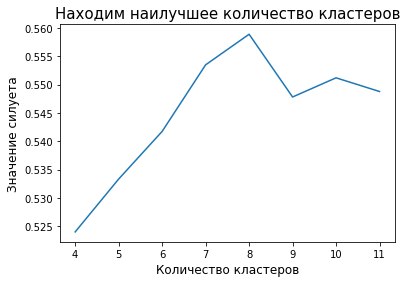

In [19]:
sil,clust = [],[]

for i in range(4,12):
    kmeans_search = KMeans(n_clusters=i, random_state=1)
    numeric_cols = df1._get_numeric_data().dropna(axis=1)
    kmeans_search.fit(numeric_cols)
    res_kmeans_search = metrics.silhouette_score(numeric_cols, kmeans_search.labels_)
    #print('Силуэт= ' + str(res_kmeans_search)+' '+str(i)+' Кластеров ')
    sil.append(res_kmeans_search)
    clust.append(i)
    
plt.plot(clust,sil)
figure = plt.gcf()
plt.xlabel('Количество кластеров', fontsize = 12)
plt.ylabel('Значение силуета', fontsize = 12)
plt.title('Находим наилучшее количество кластеров', fontsize = 15)

i = sil.index(max(sil))
print('\nЛучшее значение = ' + str(max(sil))+ '\nПри количестве кластеров = ' + str(clust[i]))

Видим что на 8ми кластерах Силуэт самый лучший.

Силуэт= 0.558867287932033


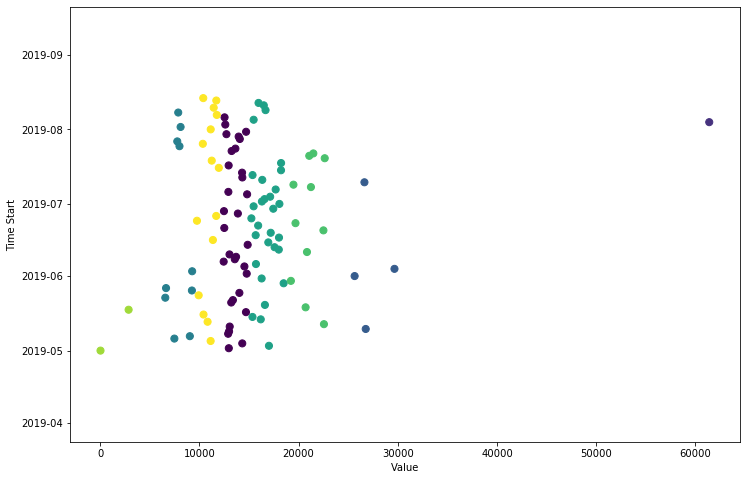

In [20]:
kmeans = KMeans(n_clusters=8, random_state=1)
numeric_cols = df1._get_numeric_data().dropna(axis=1)
kmeans.fit(numeric_cols)

plt.figure(figsize=(12,8))
plt.scatter(df1['Value'], df1['Time Start'], c=kmeans.labels_, s=50, cmap='viridis')
plt.xlabel('Value')
plt.ylabel('Time Start')

res_kmeans = metrics.silhouette_score(numeric_cols, kmeans.labels_)
print('Силуэт= ' + str(res_kmeans))

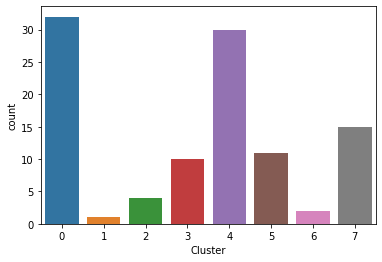

In [21]:
df1['Cluster'] = kmeans.labels_
sns.countplot(x='Cluster', data=df1);

In [37]:
df1['Cluster'].value_counts()

0    32
4    30
7    15
5    11
3    10
2     4
6     2
1     1
Name: Cluster, dtype: int64

#### Подумаем как объединить наши кластера в 4 которые даны в задании.
Вообще прикидывая на себе и своих товарищах, я пришел к выводу что за три месяца необычных дней случается 5-10. 
##### Необычные дни
Поэтому я думаю что надо взять два крайних кластера в качестве необычных дней в "общей тучке" (все кластеры кроме первого, где одно значение 60000 шагов), это будут: 
кластер 6(в котором 2 значения) прошли МЕНЬШЕ чем обычно 
кластеры 2  (в котором 4 значения) и 1 (наша бего вело гонка ;), 1 значение) прошли БОЛЬШЕ чем обычно
##### Обычные дни
В качестве Обычных дней возьмем три центральных кластера из "общей тучки" под номерами 0,4,7
##### Непонятные дни
И в качестве непонятных дней возьмем два оставшихся по номерами 3,5.
##### P.S.
Не факт что я придумал это разделение правильно, трудно выбрать какую то определенную метрику, но если нужно  попасть в субъективное ощущение пользователя, то я представляю себя пользователем, а еще я спросил у 5ти человек, своих знакомых, и убедился что их среднее мнение совпадает с моим, думаю такие проблемы решаются и на уровне бизнеса с помощью тестирования, но опять же, это мои догадки, если что готов узнать как вы это делаете :)


In [22]:
labels = kmeans.labels_
labels 

array([6, 0, 4, 0, 7, 3, 3, 0, 0, 2, 0, 5, 7, 4, 4, 7, 0, 6, 5, 4, 0, 0,
       3, 7, 0, 3, 3, 4, 5, 4, 2, 0, 3, 2, 0, 4, 0, 0, 0, 0, 5, 4, 4, 0,
       4, 7, 4, 4, 4, 5, 0, 4, 5, 7, 4, 7, 0, 0, 4, 4, 4, 4, 4, 4, 0, 0,
       4, 5, 5, 2, 4, 0, 4, 0, 4, 7, 0, 4, 7, 5, 5, 5, 0, 0, 3, 7, 3, 0,
       0, 0, 0, 7, 3, 0, 1, 4, 0, 7, 3, 4, 7, 4, 4, 7, 7], dtype=int32)

#### Давайте посмотрим на другие алгоритмы, и убедимся, что больше всего к Единице Силуэт(silhouette_score) приближен у K-means.

## Агломеративная кластеризация

Силуэт= 0.5456141795769893


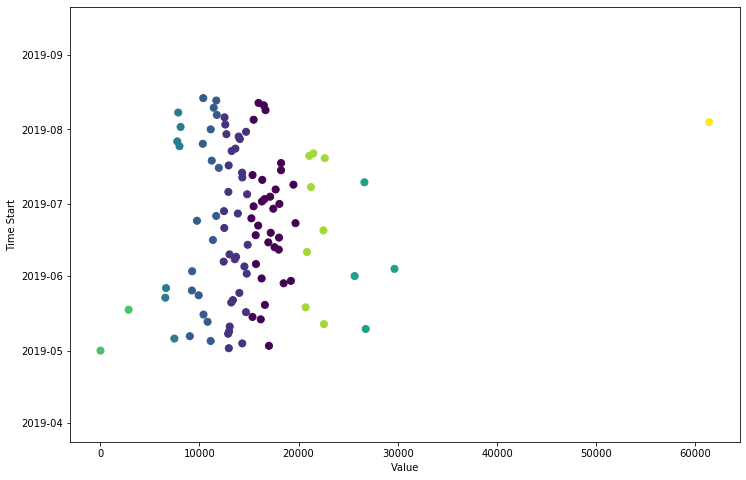

In [23]:
agglo = AgglomerativeClustering(n_clusters=8)
numeric_cols = df1._get_numeric_data().dropna(axis=1)
agglo.fit(numeric_cols)

plt.figure(figsize=(12,8))
plt.scatter(df1['Value'], df1['Time Start'], c=agglo.labels_, s=50, cmap='viridis')
plt.xlabel('Value')
plt.ylabel('Time Start')

res_agglo = metrics.silhouette_score(numeric_cols, agglo.labels_)
print('Силуэт= ' + str(res_agglo))

## Спектральная кластеризация

Силуэт= 0.40725508662312204


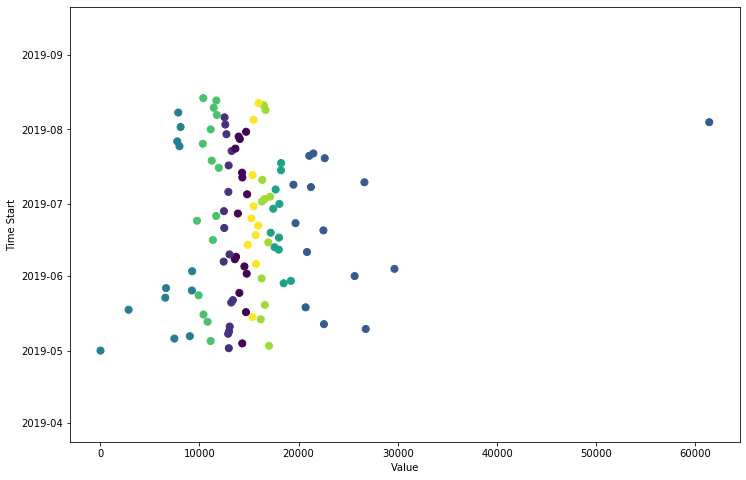

In [24]:
spectr = SpectralClustering(n_clusters=8, random_state=1, affinity='nearest_neighbors')
numeric_cols = df1._get_numeric_data().dropna(axis=1)
spectr.fit(numeric_cols)

plt.figure(figsize=(12,8))
plt.scatter(df1['Value'], df1['Time Start'], c=spectr.labels_, s=50, cmap='viridis')
plt.xlabel('Value')
plt.ylabel('Time Start')

res_spectr = metrics.silhouette_score(numeric_cols, spectr.labels_)
print('Силуэт= ' + str(res_spectr))

## Affinity Propagation

Попробуем, но вообще он нам не подойдет если выделит нечетное количество кластеров, так как ему нельзя задать число кластеров.

Силуэт= 0.5487269749399554


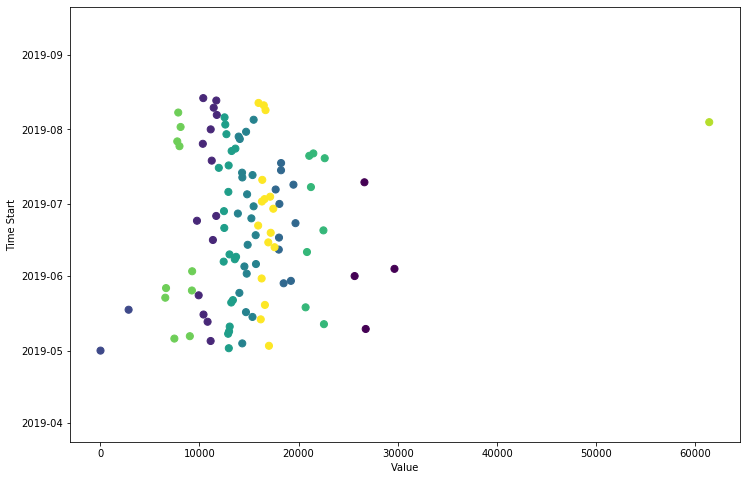

In [25]:
affin = AffinityPropagation()
numeric_cols = df1._get_numeric_data().dropna(axis=1)
affin.fit(numeric_cols)

plt.figure(figsize=(12,8))
plt.scatter(df1['Value'], df1['Time Start'], c=affin.labels_, s=50, cmap='viridis')
plt.xlabel('Value')
plt.ylabel('Time Start')

res_affin = metrics.silhouette_score(numeric_cols, affin.labels_)
print('Силуэт= ' + str(res_affin))

### K-means оказался лучшим.

In [26]:
print('Силуэты\nК-Means = ',res_kmeans,'\nAgglomerative = ', res_agglo,'\nSpectral = ', res_spectr)

Силуэты
К-Means =  0.558867287932033 
Agglomerative =  0.5456141795769893 
Spectral =  0.40725508662312204


# .
##### Обоснование выброса

In [27]:
df1[(df1['Cluster'] == 1)]

,Time Start,Value,Cluster
94,2019-08-04,61392.0,1


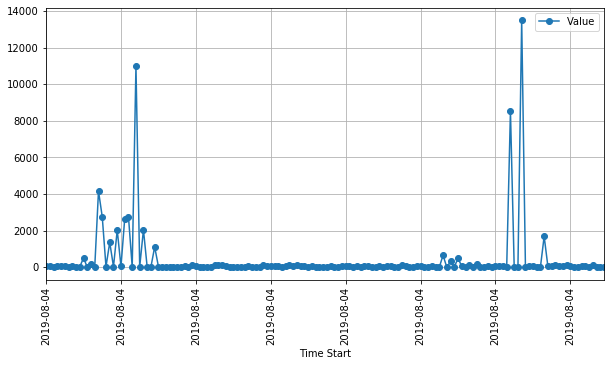

In [28]:
outlier = df[(df['Time Start'] == '2019-08-04')]
outlier.plot(x='Time Start', y='Value', rot = 90, figsize=(10, 5), grid=True, marker='o')

In [29]:
outlier[(outlier.Value > 2000)]

,Time End,Time End Local Tz,Time Offset,Time Start,Time Start Local Tz,User ID,Value
11425,2019-08-04T04:51:59+03:00,2019-08-04T07:51:59+03:00,10800,2019-08-04,2019-08-04T03:23:56+03:00,2166,4165.0
11426,2019-08-04T07:34:01+03:00,2019-08-04T10:34:01+03:00,10800,2019-08-04,2019-08-04T07:52:02+03:00,2166,2754.0
11430,2019-08-04T08:32:13+03:00,2019-08-04T11:32:13+03:00,10800,2019-08-04,2019-08-04T10:57:44+03:00,2166,2027.0
11432,2019-08-04T10:10:24+03:00,2019-08-04T13:10:24+03:00,10800,2019-08-04,2019-08-04T11:40:20+03:00,2166,2651.0
11433,2019-08-04T10:44:54+03:00,2019-08-04T13:44:54+03:00,10800,2019-08-04,2019-08-04T13:10:26+03:00,2166,2769.0
11435,2019-08-04T14:09:21+03:00,2019-08-04T17:09:21+03:00,10800,2019-08-04,2019-08-04T13:44:59+03:00,2166,10994.0
11437,2019-08-04T15:50:05+03:00,2019-08-04T18:50:05+03:00,10800,2019-08-04,2019-08-04T17:15:43+03:00,2166,2045.0
11535,2019-08-04T19:40:00+03:00,2019-08-04T22:40:00+03:00,10800,2019-08-04,2019-08-04T21:32:37+03:00,2166,8532.0
11538,2019-08-04T23:45:46+03:00,2019-08-05T02:45:46+03:00,10800,2019-08-04,2019-08-04T22:40:05+03:00,2166,13508.0


##### За 65 минут 13508 шагов это реально? ну допустим это небольшие шаги и бег трусцой тогда это будет примерно 5 км.
##### По нормативам МС бежит 5км. 14 минут, а наш объект(носитель браслета) пробежал за 65 минут (22:40:05-23:45:46), видимо этот день можно не считать за выброс, а принять как необычный!
(с пяти утра и до обеда высокая активность и вечером тоже высокая активность, мне кажется что он делал пробежки)
Загуглив дату 2019-08-04 вот что увидел  Беговелогонка Достигая Цели , прикольно! хотя может и совпадение :)

http://play-gallery.ru/2019-08-04-%D0%B1%D0%B5%D0%B3%D0%BE%D0%B2%D0%B5%D0%BB%D0%BE%D0%B3%D0%BE%D0%BD%D0%BA%D0%B0-%D0%B4%D0%BE%D1%81%D1%82%D0%B8%D0%B3%D0%B0%D1%8F-%D1%86%D0%B5%D0%BB%D0%B8


# .

## Какие еще были идеи

#### Добавить новый признак "DayWeek"

##### Добавим дни недели, ведь выходной и будний день, могут быть обычными но будут различаться

In [29]:
df1 = df1.reset_index()

def rule(x):
    a = x%7
    return a
    
df1['WeekDay'] = df1.apply(lambda x: rule(x['index']),axis=1)
df1 = df1.drop(['index'], axis=1)

df1.head()

,Time Start,Value,Cluster,WeekDay
0,2019-05-01,21.0,3,0
1,2019-05-02,12956.0,0,1
2,2019-05-03,17003.0,0,2
3,2019-05-04,14312.0,0,3
4,2019-05-05,11124.0,3,4


##### Но проблема в том, что WeekDay категориальный признак, а в K-means категориальные признаки не имеют смысла.
###### Вроде как есть способы, такие как преобразование в двоичный код, но я не смог такое сделать средствами python...
###### Хотелось применить StandardScaler() к двум признакам , но особого смысла не понял, ведь я использую в итоге один признак, количество шагов.